In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import pandas as pd
from datetime import datetime
import numpy as np;
import scipy as sp;
import sklearn;
import sys;

from nltk.corpus import stopwords;
import nltk;
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import pickle;
from scipy import linalg

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS


# Korean News

Some resources from [here](https://www.lucypark.kr/courses/2015-ba/text-mining.html)

## Clean Data

In [12]:
import string
from konlpy.tag import Kkma; 

In [13]:
df_c = pd.read_csv("data/naver_news_contacttracing.csv")
df_p = pd.read_csv("data/naver_news_patientspread.csv")
df_c.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)
df_p.drop(columns="Unnamed: 0", inplace=True)

In [14]:
df = pd.concat([df_c, df_p])
df.reset_index(drop=True, inplace=True)

In [15]:
df.keywords.unique()

array(['코로나 역학조사', '확진자 추적'], dtype=object)

In [16]:
# The null ones
print(len(df[df['text'].isnull()]))

# Just drop the null ones. There are only 4
df = df[~df['text'].isnull()]

4


In [17]:
def clean_text(text):
    remove_char = string.punctuation + '…' + '\xa0' + '·' + '\n' + \
        '※' + '‘' + '’' + '\'' + '▲' + '∼' + "△" + "“" + "”" + "▶" + "․" + \
        "▸"
    text = re.sub('http[s]?://\S+', '', text) # Remove http urls
    text = re.sub('\S*@\S*\s?', '', text) # Remove emails
    text = re.sub(r'\[.*?\]', '', text) # Remove text in square brackets
    text = re.sub(r'[%s]' % re.escape(remove_char), '', text) # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text) # Remove words containing numbers
    text = re.sub('\'', '', text)
    text = re.sub(r'Copyright .* rights reserved', '', text) # Remove "Copyright all rights reserved"
    return text


In [18]:
df['text_clean'] = pd.DataFrame(df.text.apply(lambda x: clean_text(x)))

## Tokenize

In [ ]:
# Break text into its morphemes
# FYI this takes forever

from konlpy.tag import Okt  
okt=Okt()  
texts_ko = [okt.morphs(doc) for doc in df['text_clean']]
# print(texts_ko[0])

In [ ]:
# Tokenize the morphemes
from itertools import chain

ko = nltk.Text(texts_ko)
ko_list = list(chain.from_iterable(ko.tokens))
len(ko_list), len(set(ko_list))

In [ ]:
# Korean stop words from https://github.com/stopwords-iso/stopwords-ko
import json
with open('korean_stopwords.json') as f:
  stopwords = json.load(f)

# Add some extra words
stopwords.extend(['에서', '으로', '이다', '는', '한', '은', '씨', 'A', '서', '다', '했다', '하는', 'ㆍ'])

In [ ]:
ko_list.count('코로나') 

In [ ]:
df['text_tokenized'] = texts_ko

In [ ]:
# Remove stopwords from tokens
# This takes a while
# but not TOO long of a while
# It's like an okay kind of while I guess
df['text_tokenized'] = df['text_tokenized'].apply(lambda x: [a for a in x if a not in stopwords])


In [ ]:
df.head()

In [ ]:
df.to_csv("naver_news_proc.csv")

## Topic Modeling

In [1197]:
def show_topics(a, vocab, num_top_words):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [ ]:
pd.read_csv("naver_news_proc.csv")

In [1198]:
conservative = df[df.outlet.str.contains("조선일보|중앙일보|동아일보")]
liberal = df[df.outlet.str.contains("한겨레|경향신문")]

AttributeError: 'DataFrame' object has no attribute 'outlet'

In [813]:
def nmf_topic_modeling(df, num_topics, num_top_words):
    documents = [' '.join(a) for a in df.text_tokenized]
    
    vectorizer = TfidfVectorizer(min_df=1, lowercase=False)
    vectors = vectorizer.fit_transform(documents)
    clf = NMF(n_components=num_topics, random_state=1, init='nndsvd')
    W1 = clf.fit_transform(vectors)
    H1 = clf.components_
    vocab = np.array(vectorizer.get_feature_names())
    return show_topics(H1, vocab, num_top_words)

In [820]:
nmf_topic_modeling(conservative, 7, 10)

['환자 우한 중국 했다 감염 폐렴 에서 으로 신종 국내',
 '입국 외국인 모든 격리 대상 비자 경우 자가 지정 경유',
 '클럽 이태원 진자 감염 서울 방문 관련 방역 용산구 노래방',
 '신천지 교회 대구 신도 교인 예배 명단 대구시 과천 했다',
 '추천 환자 병사 남북 전선 용서 분대 벌겠다고 오세요 미안해',
 '판정 진자 확진 병원 에서 으로 검사 지난 받았다 환자',
 '등교 학생 수업 학교 물류 연기 교육부 쿠팡 유치원 센터']

In [821]:
nmf_topic_modeling(liberal, 7, 10)

['판정 진자 확진 에서 지난 으로 받았다 여성 검사 거주',
 '했다 감염 에서 하는 정부 으로 사회 대응 방역 한다',
 '신천지 교회 신도 교인 예배 대구 명단 대구시 참석 과천',
 '등교 학생 수업 학교 교육청 교육부 학원 연기 개학 고등학교',
 '부산 부산시 진자 경남 온천 에서 판정 부산진구 동래구 격리',
 '클럽 이태원 인천 감염 서울 방문 학원 방문자 관련 검사',
 '환자 병원 신종 으로 중국 본부 코로나바이러스 감염 격리 접촉']

In [816]:
# This is on all
nmf_topic_modeling(df, 20, 10)

['환자 본부 접촉 감염 확인 관리 신종 본부장 국내 질병',
 '입국 외국인 모든 격리 대상 비자 경우 자가 경유 지정',
 '클럽 이태원 감염 서울 방문 방문자 용산구 주점 방역 진자',
 '신천지 교인 대구 신도 명단 교회 대구시 과천 수사 조사',
 '정부 감염 대응 사회 하고 방역 감염병 한국 정보 확산',
 '추천 전선 용서 삐라 벌겠다고 수리온 매단 푼돈 하겠다니이 미안해',
 '등교 학생 수업 학교 연기 교육부 유치원 교육청 개학 고등학교',
 '콜센터 직원 구로구 빌딩 코리아 서울 집단 근무 인천 감염',
 '병원 대구 입원 환자 대구시 경북 대남 의료 간호사 청도',
 '분당 제생병원 경기도 성남시 병원 누락 분당구 사관 역학 직원',
 '천안 줌바 댄스 충남 충남도 천안시 강사 아산 진자 워크숍',
 '부산 부산시 온천 동래구 진자 해운대 해운대구 부산진구 여성 격리',
 '물류 쿠팡 센터 부천 근무 부천시 직원 진자 방역 감염',
 '판정 확진 지난 받았다 검사 진자 양성 방문 여성 격리',
 '인천 학원 강사 미추홀 판정 노래방 확진 과외 감염 연수구',
 '교회 예배 은혜 신도 목사 성남시 참석 감염 소금물 온천',
 '진자 신규 서울시 관련 증가 발생 추가 기준 해외 홈페이지',
 '미군 캠프 기지 대구 부대 장병 사령부 병사 번째 캐럴',
 '우한 폐렴 중국 감염증 신종 국내 코로나바이러스 코로나 바이러스 우한시',
 '경남 창원 남도 노래방 진자 거창 진주 한마음 창녕 합천']

In [ ]:
def lda_topic_modeling(df, num_topics, num_top_words):
    documents = [' '.join(a) for a in df.text_tokenized]
    
    vectorizer = CountVectorizer(analyzer='word', min_df=3, stop_words='english', token_pattern='[a-zA-Z0-9]{3,}', max_features=5000)
    vectors = vectorizer.fit_transform(documents)

    clf = LatentDirichletAllocation(n_components=num_topics, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
    
    W1 = clf.fit_transform(vectors)
    H1 = clf.components_
    vocab = np.array(vectorizer.get_feature_names())
    return show_topics(H1, vocab, num_top_words)


## Top Frequent

In [892]:
import itertools
import ast


In [916]:
# https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists

def list_flatten(l, a=None):
    #check a
    if a is None:
        #initialize with empty list
        a = []

    for i in l:
        if isinstance(i, list):
            list_flatten(i, a)
        else:
            if (len(i) != 1): a.append(i)
    return a

In [895]:
lib_freq = list_flatten(liberal.text_tokenized.values)
lib_dist = nltk.FreqDist(lib_freq)

In [934]:
top_frequent = []
for keys in lib_dist.most_common(50):
    print(keys)
    a,b = keys
    top_frequent.append(a)

('으로', 6024)
('에서', 6020)
('진자', 5158)
('했다', 5059)
('감염', 3846)
('하고', 3075)
('있다', 2896)
('확진', 2731)
('환자', 2612)
('판정', 2608)
('검사', 2535)
('하는', 2519)
('조사', 2496)
('이다', 2221)
('병원', 2144)
('격리', 2067)
('방역', 2065)
('지난', 2005)
('접촉', 1947)
('역학', 1879)
('발생', 1626)
('지역', 1623)
('신천지', 1608)
('밝혔다', 1556)
('됐다', 1506)
('확인', 1455)
('증상', 1339)
('방문', 1308)
('교회', 1289)
('있는', 1228)
('관리', 1200)
('대구', 1197)
('의료', 1129)
('관련', 1098)
('당국', 1086)
('추가', 1061)
('서울', 1041)
('자가', 1009)
('대한', 985)
('받았다', 980)
('사회', 980)
('본부', 970)
('확산', 956)
('까지', 930)
('결과', 925)
('정부', 925)
('오후', 914)
('파악', 876)
('중국', 869)
('현재', 865)


In [935]:
' '.join([item for item in top_frequent if item not in stopwords])

'진자 감염 하고 확진 환자 판정 검사 조사 병원 격리 방역 지난 접촉 역학 발생 지역 신천지 밝혔다 됐다 확인 증상 방문 교회 있는 관리 대구 의료 관련 당국 추가 서울 자가 대한 받았다 사회 본부 확산 결과 정부 오후 파악 중국 현재'

In [936]:
con_freq = list_flatten(conservative.text_tokenized.values)
con_dist = nltk.FreqDist(con_freq)

In [937]:
top_frequent = []
for keys in con_dist.most_common(50):
    print(keys)
    a,b = keys
    top_frequent.append(a)
    
' '.join([item for item in top_frequent if item not in stopwords])

('입국', 30080)
('에서', 20881)
('격리', 20112)
('외국인', 16207)
('으로', 15948)
('모든', 13536)
('진자', 12015)
('했다', 11863)
('대상', 11614)
('검사', 10161)
('하는', 9904)
('방문', 9384)
('감염', 9210)
('자가', 8659)
('환자', 8633)
('경우', 8601)
('하고', 7534)
('지역', 7332)
('중국', 7303)
('시설', 6720)
('국민', 6717)
('한국', 6622)
('확진', 6532)
('판정', 6477)
('있다', 6327)
('확인', 5962)
('병원', 5699)
('발생', 5496)
('지정', 5266)
('조사', 5211)
('비자', 5177)
('국가', 5045)
('방역', 4981)
('관련', 4820)
('거주', 4702)
('코로나', 4638)
('접촉', 4574)
('이다', 4320)
('신종', 4164)
('조치', 4080)
('또는', 4062)
('음성', 4019)
('증상', 3987)
('가능', 3952)
('있는', 3900)
('지난', 3825)
('금지', 3797)
('경유', 3793)
('이내', 3777)
('이탈리아', 3691)


'입국 격리 외국인 모든 진자 대상 검사 방문 감염 자가 환자 경우 하고 지역 중국 시설 국민 한국 확진 판정 확인 병원 발생 지정 조사 비자 국가 방역 관련 거주 코로나 접촉 신종 조치 또는 음성 증상 가능 있는 지난 금지 경유 이내 이탈리아'

# American News

## Clean Data (merge american news datasets)

In [1157]:
cnn = pd.read_csv("data/cnn.csv")
fox = pd.read_csv("data/fox.csv")
nyt = pd.read_csv("data/nyt.csv")
wp = pd.read_csv("data/washingtonpost.csv")
usa = pd.read_csv("data/usatoday.csv")

dailycaller = pd.read_csv("data/dailycaller.csv")
breitbart = pd.read_csv("data/breitbart.csv")


In [1158]:
cnn["source"] = "cnn"
fox["source"] = "fox"
nyt["source"] = "nyt"
dailycaller["source"] = "dailycaller"
breitbart["source"] = "breitbart"
nyt.rename(columns={"body": "text"}, inplace=True)
wp["source"] = "washington post"
usa["source"] = "usa today"
usa.drop(columns="Unnamed: 0.1", inplace=True)


In [1159]:
wp.columns, usa.columns, fox.columns, nyt.columns, cnn.columns, dailycaller.columns, breitbart.columns

(Index(['Unnamed: 0', 'title', 'date', 'url', 'text', 'source'], dtype='object'),
 Index(['Unnamed: 0', 'title', 'date', 'url', 'text', 'source'], dtype='object'),
 Index(['Unnamed: 0', 'title', 'date', 'url', 'text', 'source'], dtype='object'),
 Index(['Unnamed: 0', 'title', 'date', 'url', 'text', 'source'], dtype='object'),
 Index(['Unnamed: 0', 'title', 'date', 'url', 'text', 'source'], dtype='object'),
 Index(['title', 'date', 'url', 'text', 'source'], dtype='object'),
 Index(['title', 'date', 'url', 'text', 'source'], dtype='object'))

In [1160]:
df = pd.concat([cnn, fox, nyt, wp, usa, dailycaller, breitbart])
df["keyword"] = "contact tracing"
df.drop(columns="Unnamed: 0", inplace=True)
df.reset_index(drop=True, inplace=True)

In [1161]:
# These are all the null ones, usually due to being video, radio, or interactive files. We will drop these
nullvals = df[df['text'].isnull()]
print(len(nullvals))

df = df[df['text'].notna()]
print(len(df))

27
3623


In [1162]:
# Fix dates with weird formats
df['date2'] = pd.to_datetime(df.date, errors="coerce")
a = df[df['date2'].isnull()].date.str.extract("(.*)T", expand=False)
df.loc[a.index, "date2"] = a.values

df['date'] = pd.to_datetime(df['date2'], utc=True).dt.date
df.drop(columns="date2", inplace=True)

/Users/yenniejun/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [1163]:
df[df['date'].isnull()]

,title,date,url,text,source,keyword


In [1164]:
df[df['text'].isnull()]

,title,date,url,text,source,keyword


In [1165]:
df.sort_values(by="date", inplace=True)

# Drop the things before 2020-01-01
df = df.loc[df.date > pd.to_datetime("2020-01-01").date()]
df.reset_index(inplace=True, drop=True)

In [1166]:
df.to_csv("us_news.csv")

## Preprocess Data (lemmatize, stem)

In [1167]:
# https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
np.random.seed(2018)

In [1168]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yenniejun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [1169]:
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))


def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
#             result.append(WordNetLemmatizer().lemmatize(token, pos='v'))
            result.append(lemmatize_stemming(token))
    return result

In [1170]:
doc_sample = df[df.index == 0].text.values[0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
# print(words)
# print('\n\n tokenized and lemmatized document: ')
# print(preprocess(doc_sample))

original document: 


In [1171]:
df['text_proc'] = df['text'].map(preprocess)
df['text_proc'] = df['text_proc'].apply(lambda a: ' '.join(a))

df.head()

,title,date,url,text,source,keyword,text_proc
0,At SoftBank’s Jewel in India: ‘Toxic’ Culture ...,2020-01-02,https://www.nytimes.com/2020/01/02/technology/...,"NEW DELHI — Oyo, a start-up that offers budget...",nyt,contact tracing,delhi start offer budget hotel room grow india...
1,The Week in Tech: Our Hidden Gems of 2019,2020-01-03,https://www.nytimes.com/2020/01/03/business/te...,"Each week, we review the week’s news, offering...",nyt,contact tracing,week review week news offer analysi import dev...
2,Stressed Out,2020-01-04,https://www.nytimes.com/2020/01/04/crosswords/...,SUNDAY PUZZLE — Will Nediger is a welcome sigh...,nyt,contact tracing,sunday puzzl nedig welcom sight sunday puzzl t...
3,"Zoë Harris, Simon Lazarre-Bloom",2020-01-05,https://www.nytimes.com/2020/01/05/fashion/wed...,Zoë Kimberly Harris and Simon Lazarre-Bloom we...,nyt,contact tracing,kimber harri simon lazarr bloom marri francisc...
4,Companies making AI for analyzing satellite im...,2020-01-05,https://www.foxnews.com/tech/artificial-intell...,"[""Gordon Chang, author of 'The Coming Collapse...",fox,contact tracing,gordon chang author come collaps china offer r...


In [1172]:
# Remove stopwords
# df['text_proc'].apply(lambda x: [a for a in x if a not in stopwords])


In [1173]:
df.to_csv("us_news_proc.csv")

## Explore Data

In [1174]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [1175]:
df = pd.read_csv("us_news_proc.csv")
df.drop(columns="Unnamed: 0", inplace=True)

In [1176]:
df.source.unique()

array(['nyt', 'fox', 'washington post', 'cnn', 'dailycaller', 'usa today',
       'breitbart'], dtype=object)

In [1177]:
# Articles that specifically mention contact tracing
len(df[df['text'].str.contains("contact tracing")])

1990

In [1178]:
liberal = df[df.source.str.contains("nyt|washington post|cnn")].reset_index()

In [1179]:
conservative = df[df.source.str.contains("fox|dailycaller|breitbart")]

In [1180]:
len(liberal), len(conservative)

(2910, 484)

### Frequent Words

In [1181]:
# Frequent words
def list_flatten(l, a=None):
    #check a
    if a is None:
        #initialize with empty list
        a = []

    for i in l:
        if isinstance(i, list):
            list_flatten(i, a)
        else:
            if (len(i) != 1): a.append(i)
    return a

In [1182]:
def find_top_frequent_words(documents, top_n):
    dist = nltk.FreqDist(documents)
    top_frequent = []
    for keys in dist.most_common(top_n):
#         print(keys)
        a,b = keys
        top_frequent.append(keys)
    return top_frequent

In [1183]:
con = [a.split() for a in conservative.text_proc.values]
con = list_flatten(con)
find_top_frequent_words(con, 50)

[('say', 2586),
 ('coronavirus', 2252),
 ('peopl', 2112),
 ('state', 1821),
 ('test', 1490),
 ('go', 1466),
 ('news', 1437),
 ('know', 1371),
 ('think', 1313),
 ('health', 1200),
 ('presid', 1197),
 ('case', 1054),
 ('like', 991),
 ('right', 985),
 ('time', 962),
 ('countri', 895),
 ('trump', 872),
 ('report', 865),
 ('virus', 857),
 ('come', 855),
 ('work', 855),
 ('need', 821),
 ('covid', 815),
 ('want', 760),
 ('reopen', 725),
 ('click', 717),
 ('contact', 716),
 ('week', 709),
 ('tell', 688),
 ('home', 673),
 ('trace', 669),
 ('look', 642),
 ('thing', 632),
 ('public', 625),
 ('busi', 571),
 ('number', 568),
 ('american', 557),
 ('infect', 553),
 ('governor', 545),
 ('begin', 540),
 ('york', 532),
 ('hous', 531),
 ('pandem', 527),
 ('govern', 521),
 ('spread', 520),
 ('nation', 514),
 ('wallac', 505),
 ('biden', 485),
 ('death', 481),
 ('year', 473)]

In [1184]:
lib = [a.split() for a in liberal.text_proc.values]
lib = list_flatten(lib)
find_top_frequent_words(lib, 50)

[('say', 65397),
 ('coronavirus', 39599),
 ('peopl', 32201),
 ('state', 30829),
 ('case', 30154),
 ('test', 29749),
 ('health', 29323),
 ('virus', 18940),
 ('countri', 17193),
 ('report', 15782),
 ('death', 15473),
 ('week', 14631),
 ('infect', 13997),
 ('covid', 13838),
 ('govern', 13170),
 ('public', 12898),
 ('need', 12408),
 ('trump', 12322),
 ('like', 12256),
 ('home', 12172),
 ('work', 12106),
 ('time', 12079),
 ('reopen', 12077),
 ('offici', 12049),
 ('number', 11945),
 ('accord', 11643),
 ('pandem', 11401),
 ('spread', 11383),
 ('includ', 10524),
 ('citi', 10509),
 ('presid', 10215),
 ('nation', 10051),
 ('hospit', 10044),
 ('mask', 9813),
 ('contact', 9103),
 ('go', 8961),
 ('outbreak', 8931),
 ('come', 8772),
 ('tell', 8681),
 ('diseas', 8490),
 ('day', 8477),
 ('year', 8388),
 ('patient', 8373),
 ('social', 8353),
 ('world', 8340),
 ('china', 8328),
 ('know', 8309),
 ('news', 8289),
 ('care', 8180),
 ('symptom', 8114)]

### Word Clouds

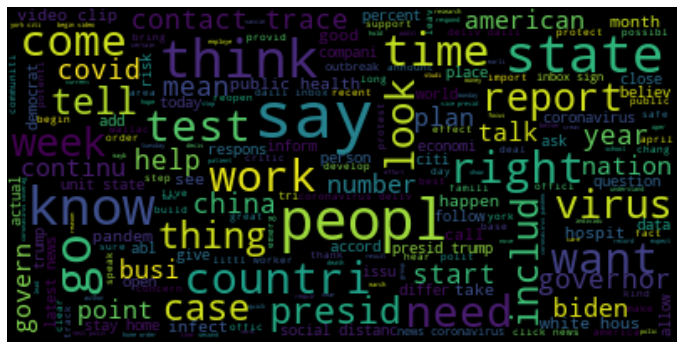

In [1185]:
con = ' '.join(conservative.text_proc.values)

wordcloud = WordCloud(max_font_size=40).generate(con)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [1186]:
lib = ' '.join(liberal.text_proc.values)

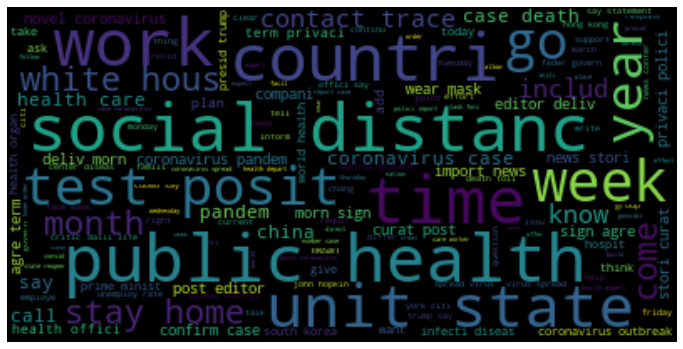

In [1187]:
wordcloud = WordCloud(max_font_size=40).generate(lib)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Topic Modeling

### LDA

In [1188]:
def show_topics(a, vocab, num_top_words):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [1189]:
# https://medium.com/ml2vec/topic-modeling-is-an-unsupervised-learning-approach-to-clustering-documents-to-discover-topics-fdfbf30e27df
def lda_topic_modeling(df, num_topics, num_top_words):
    documents = [''.join(a) for a in df.text_proc]
    
    vectorizer = CountVectorizer(analyzer='word', min_df=3, stop_words='english', token_pattern='[a-zA-Z0-9]{3,}', max_features=5000)
    vectors = vectorizer.fit_transform(documents)

    clf = LatentDirichletAllocation(n_components=num_topics, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
    
    W1 = clf.fit_transform(vectors)
    H1 = clf.components_
    vocab = np.array(vectorizer.get_feature_names())
    return show_topics(H1, vocab, num_top_words)


In [1190]:
lda_topic_modeling(conservative, num_topics = 6, num_top_words = 15)

['news compani googl click say coronavirus china report technolog tech research user appl check app',
 'amazon gift polic year lincoln monster game florida speed internet tampa beach click photograph plan',
 'weapon attack whitmer forc carrier oper navi missil rang mission space bring flight nuclear technolog',
 'coronavirus say test state health peopl case news covid contact report virus trace reopen infect',
 'peopl think know presid say right state like want trump come time thing look biden',
 'click card free iphon phone sell onlin radio right data komando game time drone network']

In [1191]:
lda_topic_modeling(liberal, num_topics = 6, num_top_words = 15)

['say case death countri lockdown virus coronavirus week report rise restrict govern infect peopl increas',
 'test state say trump peopl health coronavirus public need contact reopen pandem trace presid offici',
 'peopl coronavirus symptom say percent test mask seat spread infect state virus like day exercis',
 'case coronavirus say health china virus countri peopl travel outbreak infect offici confirm test spread',
 'say time year like peopl know think work polic protest student come want live school',
 'say coronavirus state case health test death peopl covid accord report reopen number week countri']

### NMF

In [1192]:
def nmf_topic_modeling(df, num_topics, num_top_words):
    documents = [''.join(a) for a in df.text_proc]
    
    vectorizer = TfidfVectorizer(min_df=1, lowercase=False)
    vectors = vectorizer.fit_transform(documents)
    clf = NMF(n_components=num_topics, random_state=1, init='nndsvd')
    W1 = clf.fit_transform(vectors)
    H1 = clf.components_
    vocab = np.array(vectorizer.get_feature_names())
    return show_topics(H1, vocab, num_top_words)

In [1195]:
nmf_topic_modeling(conservative, num_topics = 7, num_top_words = 15)

['state reopen coronavirus say order busi cuomo case plan governor phase economi open york home',
 'think go wallac know right peopl like want clip thing cavuto presid video thank look',
 'googl appl app user privaci tech compani data contact technolog phone trace devic smartphon giant',
 'case coronavirus china infect health virus say diseas covid spread outbreak offici countri report peopl',
 'protest blasio citi floyd georg mayor york polic peopl riot gather death demonstr atlanta cuomo',
 'trump presid biden whitmer hous white democrat michigan coronavirus say vice campaign penc fauci administr',
 'test health posit coronavirus contact isol need peopl say worker employe infect trace covid care']

In [1196]:
nmf_topic_modeling(liberal, num_topics = 7, num_top_words = 15)

['china case coronavirus health say countri virus travel wuhan outbreak peopl infect chines confirm offici',
 'symptom seat percent peopl exercis coronavirus say surfac mask touch fever spread day wear transmiss',
 'trump say presid hous white state biden administr democrat republican fauci coronavirus american senat governor',
 'test state peopl need infect coronavirus virus covid health stori antibodi case reopen curat sign',
 'googl appl data compani technolog app tech privaci smartphon user bluetooth track contact trace phone',
 'say case death state total report rise daili reopen accord governor minist week lockdown increas',
 'say maryland virginia counti state district health hogan reopen citi case offici school coronavirus northam']

## SVD


In [293]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)


CPU times: user 8.59 s, sys: 639 ms, total: 9.22 s
Wall time: 6.33 s


In [294]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [295]:
show_topics(Vh[:10])


['exosuit ufos scuba misappropriated immerse nonindividualization vibrancy treatise',
 'cases coronavirus china confirmed health outbreak novel case',
 'said state according trump today cnn cases announced',
 'state tested case public testing symptoms contact said',
 'health life daily trump travel business president coronavirus',
 'cases new states united tested positive president italy',
 'travel president testing covid 19 vaccine tuesday reopening',
 'health wednesday tuesday state states thursday covid 19',
 'state travel city announced wuhan restrictions wednesday health',
 'thursday friday people positive hall tested town saturday']